In [ ]:
!pip -q install torch_geometric torchdiffeq

In [26]:
import torch_geometric as torchg
import torch
import torch.nn as nn
import torch_geometric.nn as gnn

import matplotlib.pyplot as plt

from torchdiffeq import odeint

from tqdm.auto import tqdm

import seaborn as sns

sns.set_style("whitegrid")


class GRANDBlock(nn.Module):
    def __init__(self, num_heads, num_chanels, featurs_dim, out_dim):
        super().__init__()

        self.num_heads = num_heads
        self.num_chanels = num_chanels
        self.featurs_dim = featurs_dim
        self.out_dim = out_dim

        self.register_buffer("eye", torch.eye(self.num_chanels))

        self.k = nn.Linear(self.featurs_dim, self.out_dim * self.num_heads)
        self.q = nn.Linear(self.featurs_dim, self.out_dim * self.num_heads)
        self.v = nn.Linear(self.featurs_dim, self.out_dim * self.num_heads)

        self.w0 = nn.Linear(self.out_dim * self.num_heads, self.out_dim)

    def forward(
        self,
        x,
    ):  # just x cause we hawe complete graph where edge weight is att score
        nodes = torch.arange(x.shape[0])
        edge_idx = torch.stack(
            [nodes.repeat(len(nodes)), nodes.repeat_interleave(len(nodes))], dim=0
        )

        k = self.k(x).reshape(-1, self.num_heads, self.num_chanels, self.out_dim)
        q = self.q(x).reshape(-1, self.num_heads, self.num_chanels, self.out_dim)
        v = self.v(x).reshape(-1, self.num_heads, self.num_chanels, self.out_dim)

        att_scores = torch.einsum("bhcf,bhdf->bhcd", q, k) / (self.out_dim**0.5)
        vals = torch.einsum(
            "bhcd,bhdf->bhcf",
            torch.softmax(att_scores, dim=-1) - self.eye,
            v,
        )

        vals = vals.permute(0, 2, 1, 3)  # [B, C, H, F]
        vals = vals.reshape(vals.size(0), vals.size(1), self.num_heads * self.out_dim)

        return self.w0(vals)


class ODEFunc(nn.Module):
    def __init__(self, func, **kwargs):
        super().__init__()

        self.func = func
        self.kwargs = kwargs

    def forward(self, t, x):
        return self.func(x)


class GRAND(nn.Module):
    def __init__(self, num_heads, num_chanels, featurs_dim, out_dim):
        super().__init__()

        self.grand_encoder = ODEFunc(
            GRANDBlock(num_heads, num_chanels, featurs_dim, out_dim)
        )
        self.grand_decoder = ODEFunc(
            GRANDBlock(num_heads, num_chanels, featurs_dim, out_dim)
        )
        self.ln = nn.Linear(num_chanels, 3)

    def forward(self, x, t):
        z = odeint(self.grand_encoder, x, t, method="rk4")[-1]
        x_hat = odeint(self.grand_decoder, x, t, method="rk4")[-1]

        return self.ln(z.permute(0, 2, 1)).permute(0, 2, 1), x_hat


def lorenz_attractor(
    y0=(0.1, 0.0, 0.0), t1=50.0, dt=0.01, sigma=10.0, rho=28.0, beta=8 / 3
):
    y0 = torch.Tensor(y0)
    t = torch.arange(0, t1 + dt, dt)
    traj = torch.zeros((len(t), 3))
    traj[0] = y0

    def f(y):
        x, yv, z = y
        return torch.Tensor([sigma * (yv - x), x * (rho - z) - yv, x * yv - beta * z])

    for i in range(len(t) - 1):
        y = traj[i]
        k1 = f(y)
        k2 = f(y + 0.5 * dt * k1)
        k3 = f(y + 0.5 * dt * k2)
        k4 = f(y + dt * k3)
        traj[i + 1] = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    return traj


def nonlinear_observation(traj: torch.Tensor) -> torch.Tensor:
    x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]
    x_nl = torch.tanh(x + y**2 - z)
    y_nl = torch.sin(y + z**2 - x)
    z_nl = torch.tanh(z + x**2 - y)
    return torch.stack([x_nl, y_nl, z_nl], axis=1)


def multivariate_delay_embedding(
    traj_nl: torch.Tensor, d: int, tau: int
) -> torch.Tensor:
    T, num_features = traj_nl.shape
    N = T - (d - 1) * tau
    if N <= 0:
        raise ValueError("Too large embedding dimension or lag")
    embeddings = []
    for i in range(num_features):
        signal = traj_nl[:, i]
        emb_i = torch.zeros((N, d))
        for j in range(d):
            emb_i[:, j] = signal[j * tau : j * tau + N]
        embeddings.append(emb_i)
    return torch.concatenate(embeddings, axis=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Y = lorenz_attractor()
Y_nl = nonlinear_observation(Y)

X = multivariate_delay_embedding(Y_nl, d=9, tau=25)
T, num_chanels = X.shape
dt = 0.01
window_sec = 1
window_size = int(window_sec / dt)
num_windows = T // window_size
X_trimmed = X[: num_windows * window_size]

X_windows = torch.tensor(
    X_trimmed.reshape(num_windows, window_size, num_chanels), dtype=torch.float
)
X_windows = X_windows.permute(0, 2, 1).to(device)

Y_trimmed = Y[: num_windows * window_size]

Y_windows = torch.tensor(
    Y_trimmed.reshape(num_windows, window_size, 3), dtype=torch.float
)
Y_windows = Y_windows.permute(0, 2, 1).to(device)

num_heads = 4

model = GRAND(
    num_heads=num_heads,
    num_chanels=num_chanels,
    featurs_dim=window_size,
    out_dim=window_size,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.5)

criterion = nn.MSELoss()

epochs = 3000
time_to_integrate = torch.linspace(0, 10, 20).to(device)
losses = []

for epoch in tqdm(range(epochs)):
    total_loss = 0
    latents_list = []
    x_hat_list = []
    optimizer.zero_grad()

    for window in range(0, len(X_windows), 30):
        batch = X_windows[window : min(len(X_windows), window + 30)].to(device)
        z, x_hat = model(batch, time_to_integrate)
        latents_list.extend(z.permute(0, 2, 1))
        x_hat_list.extend(x_hat)

        total_loss += criterion(x_hat, batch)
        total_loss += criterion(
            z, Y_windows[window : min(len(X_windows), window + 30)].to(device)
        )

    # Z = torch.cat(latents_list, dim=0)

    # k = 3
    # U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
    # Z_reduced = U[:, :k] @ torch.diag(S[:k])

    # Y_tensor = torch.tensor(Y[:Z_reduced.shape[0]].T, dtype=torch.float, device=device)
    # total_loss += criterion(Z_reduced.T, Y_tensor)

    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
    optimizer.step()

    scheduler.step()

    total_loss_value = total_loss.item()
    losses.append(total_loss_value)
    print(
        f"Epoch {epoch+1}/{epochs}, Loss: {total_loss_value:.6f}, LR: {scheduler.get_last_lr()[0]:.2e}"
    )

Using device: cuda


/tmp/ipython-input-2951961015.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_windows = torch.tensor(
/tmp/ipython-input-2951961015.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_windows = torch.tensor(


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000, Loss: 0.301616, LR: 1.00e-05
Epoch 2/1000, Loss: 0.263149, LR: 1.00e-05
Epoch 3/1000, Loss: 0.245848, LR: 1.00e-05
Epoch 4/1000, Loss: 0.236323, LR: 1.00e-05
Epoch 5/1000, Loss: 0.228119, LR: 1.00e-05
Epoch 6/1000, Loss: 0.220686, LR: 1.00e-05
Epoch 7/1000, Loss: 0.217021, LR: 1.00e-05
Epoch 8/1000, Loss: 0.214703, LR: 1.00e-05
Epoch 9/1000, Loss: 0.212618, LR: 1.00e-05
Epoch 10/1000, Loss: 0.209331, LR: 1.00e-05
Epoch 11/1000, Loss: 0.207115, LR: 1.00e-05
Epoch 12/1000, Loss: 0.203789, LR: 1.00e-05
Epoch 13/1000, Loss: 0.201265, LR: 1.00e-05
Epoch 14/1000, Loss: 0.197986, LR: 1.00e-05
Epoch 15/1000, Loss: 0.195583, LR: 1.00e-05
Epoch 16/1000, Loss: 0.193989, LR: 1.00e-05
Epoch 17/1000, Loss: 0.192353, LR: 1.00e-05
Epoch 18/1000, Loss: 0.190571, LR: 1.00e-05
Epoch 19/1000, Loss: 0.188833, LR: 1.00e-05
Epoch 20/1000, Loss: 0.186657, LR: 1.00e-05
Epoch 21/1000, Loss: 0.185024, LR: 1.00e-05
Epoch 22/1000, Loss: 0.183454, LR: 1.00e-05
Epoch 23/1000, Loss: 0.182229, LR: 1.00e-

In [27]:
torch.save(model.state_dict(), "model_weights.pth")

/tmp/ipython-input-119791103.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_true = torch.tensor(Y[: Z_reduced.shape[0]], dtype=torch.float).cpu().numpy()


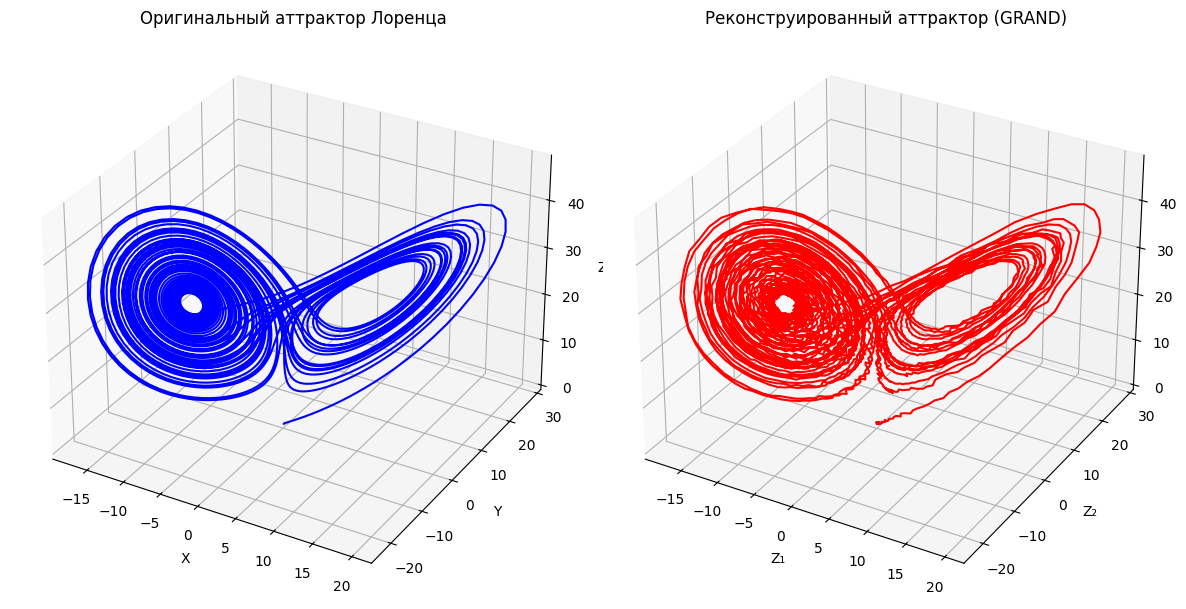

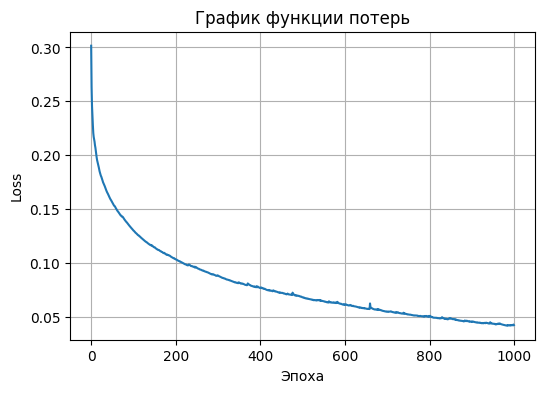

In [28]:
Z_reduced = torch.cat(latents_list, dim=0).detach().cpu()

with torch.no_grad():
    Y_true = torch.tensor(Y[: Z_reduced.shape[0]], dtype=torch.float).cpu().numpy()

    Z_final = Z_reduced.detach().cpu().numpy()

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot(Y_true[:, 0], Y_true[:, 1], Y_true[:, 2], color='blue')
    ax1.set_title("Оригинальный аттрактор Лоренца")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot(Z_final[:, 0], Z_final[:, 1], Z_final[:, 2], color='red')
    ax2.set_title("Реконструированный аттрактор (GRAND)")
    ax2.set_xlabel("Z₁")
    ax2.set_ylabel("Z₂")
    ax2.set_zlabel("Z₃")

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("График функции потерь")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()